In [1]:
from datacat4ml.DeepCoy.data.prepare_data import read_smiles, preprocess
from collections import defaultdict
import json
from datacat4ml.DeepCoy.DeepCoy import DenseGGNNChemModel
from datacat4ml.DeepCoy.evaluation.select_and_evaluate_decoys import select_and_evaluate_decoys

2025-11-13 18:44:21.502472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


# Yu's modification

## read SMILES

In [2]:
smis = ['c1c(c(ccc1c1c(n(c([C@H]2CC[N@@H+](CC2)C)n1)CCC)c1ccnc(n1)NC1CC1)Cl)Cl',
        'c1(ccc(cc1)c1c(ocn1)c1ccc2n(c1)c(nn2)c1c(cccc1)OC)F',
        'c1c(c(cc(c1)C(=O)NOC)Nc1c2c(c(cn2ncn1)C(=O)NCc1ccccc1)C)C']

In [3]:
# example usage
raw_data = read_smiles(smis)
raw_data

Finished reading: 3 / 3


[{'smiles_1': 'c1c(c(ccc1c1c(n(c([C@H]2CC[N@@H+](CC2)C)n1)CCC)c1ccnc(n1)NC1CC1)Cl)Cl',
  'smiles_2': 'c1c(c(ccc1c1c(n(c([C@H]2CC[N@@H+](CC2)C)n1)CCC)c1ccnc(n1)NC1CC1)Cl)Cl'},
 {'smiles_1': 'c1(ccc(cc1)c1c(ocn1)c1ccc2n(c1)c(nn2)c1c(cccc1)OC)F',
  'smiles_2': 'c1(ccc(cc1)c1c(ocn1)c1ccc2n(c1)c(nn2)c1c(cccc1)OC)F'},
 {'smiles_1': 'c1c(c(cc(c1)C(=O)NOC)Nc1c2c(c(cn2ncn1)C(=O)NCc1ccccc1)C)C',
  'smiles_2': 'c1c(c(cc(c1)C(=O)NOC)Nc1c2c(c(cn2ncn1)C(=O)NCc1ccccc1)C)C'}]

In [4]:
# example usage
processed_data = preprocess(raw_data, dataset='zinc')
processed_data

Parsing smiles as graphs.
Processed: 3 / 3
Saving data.
Length raw data: 	3
Length processed data: 	3


[{'graph_in': [(0, 1, 1),
   (1, 0, 2),
   (2, 1, 3),
   (3, 0, 4),
   (4, 1, 5),
   (5, 0, 6),
   (6, 1, 7),
   (7, 0, 8),
   (8, 0, 9),
   (9, 0, 11),
   (11, 0, 12),
   (12, 0, 13),
   (13, 0, 14),
   (14, 0, 15),
   (15, 0, 16),
   (14, 0, 17),
   (9, 1, 10),
   (8, 0, 18),
   (18, 0, 19),
   (19, 0, 20),
   (7, 0, 21),
   (21, 1, 22),
   (22, 0, 23),
   (23, 1, 24),
   (24, 0, 25),
   (25, 1, 26),
   (25, 0, 27),
   (27, 0, 28),
   (28, 0, 29),
   (29, 0, 30),
   (2, 0, 31),
   (1, 0, 32),
   (5, 0, 0),
   (10, 0, 6),
   (26, 0, 21),
   (30, 0, 28),
   (16, 0, 11)],
  'graph_out': [(0, 1, 1),
   (1, 0, 2),
   (2, 1, 3),
   (3, 0, 4),
   (4, 1, 5),
   (5, 0, 6),
   (6, 1, 7),
   (7, 0, 8),
   (8, 0, 9),
   (9, 0, 11),
   (11, 0, 12),
   (12, 0, 13),
   (13, 0, 14),
   (14, 0, 15),
   (15, 0, 16),
   (14, 0, 17),
   (9, 1, 10),
   (8, 0, 18),
   (18, 0, 19),
   (19, 0, 20),
   (7, 0, 21),
   (21, 1, 22),
   (22, 0, 23),
   (23, 1, 24),
   (24, 0, 25),
   (25, 1, 26),
   (25, 0, 27),

## generate decoys

In [5]:
def generate_decoys(processed_data, num_gen_per_mol=100):
    
    args = defaultdict(None)
    args['--dataset'] = 'zinc'

    config_dict = {
        "generation": True,
        "batch_size": 1,
        "number_of_generation_per_valid": num_gen_per_mol,
        "use_subgraph_freqs": False
    }

    args['--config'] = json.dumps(config_dict) # dynamic JSON
        
    model = DenseGGNNChemModel(args, train_data=processed_data, valid_data=processed_data)
    generated_all_smiles = model.train()
    # Free up memory
    model = None

    return generated_all_smiles

generated_all_smiles = generate_decoys(processed_data, num_gen_per_mol=100)

Running in in-memory mode; no params file written.
Run 2025-11-13-18-46-50_2953732 starting with following parameters:
{"task_sample_ratios": {}, "use_edge_bias": true, "clamp_gradient_norm": 1.0, "out_layer_dropout_keep_prob": 1.0, "tie_fwd_bkwd": true, "random_seed": 0, "batch_size": 1, "num_epochs": 10, "epoch_to_generate": 10, "number_of_generation_per_valid": 100, "maximum_distance": 50, "use_argmax_generation": false, "residual_connection_on": true, "residual_connections": {"2": [0], "4": [0, 2], "6": [0, 2, 4], "8": [0, 2, 4, 6], "10": [0, 2, 4, 6, 8], "12": [0, 2, 4, 6, 8, 10], "14": [0, 2, 4, 6, 8, 10, 12]}, "num_timesteps": 7, "hidden_size": 100, "encoding_size": 8, "kl_trade_off_lambda": 0.3, "learning_rate": 0.001, "graph_state_dropout_keep_prob": 1, "compensate_num": 0, "train_file": "data/molecules_train_zinc.json", "valid_file": "data/molecules_valid_zinc.json", "try_different_starting": true, "num_different_starting": 1, "generation": true, "use_graph": true, "label_one

2025-11-13 18:46:50.623453: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/storage/homefs/yc24j783/datacat4ml/datacat4ml/DeepCoy/DeepCoy.py:199: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.nn.rnn_cell.GRUCell(new_h_dim) # modified by Yu


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
keep_dims is deprecated, use keepdims instead


2025-11-13 18:46:59.889695: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2025-11-13 18:47:00.170695: W tensorflow/c/c_api.cc:291] Operation '{name:'gru_scope_decoder6/gru_cell/candidate/bias/Adam_1/Assign' id:19633 op device:{requested: '', assigned: ''} def:{{{node gru_scope_decoder6/gru_cell/candidate/bias/Adam_1/Assign}} = Assign[T=DT_FLOAT, _class=["loc:@gru_scope_decoder6/gru_cell/candidate/bias"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](gru_scope_decoder6/gru_cell/candidate/bias/Adam_1, gru_scope_decoder6/gru_cell/candidate/bias/Adam_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Generated mol 0
Generated mol 100
Generated mol 200


[18:50:07] WARNING: not removing hydrogen atom without neighbors


Generation done
Number of generated SMILES: 300


## select decoys

In [ ]:
# assess generated decoys
chosen_properties = "ALL"
num_decoys_per_active = 2

active_decoys_dict = select_and_evaluate_decoys(generated_all_smiles, dataset=chosen_properties, 
                                                num_cand_dec_per_act=num_decoys_per_active*2, num_dec_per_act=num_decoys_per_active)

Processed smiles: 0
Done calculating properties
Processed smiles: 0
Done calculating properties
Processed smiles: 0
Done calculating properties
Processed smiles: 0
Done calculating properties


[18:28:26] UFFTYPER: Unrecognized atom type: S_5+6 (5)
[18:28:26] UFFTYPER: Unrecognized atom type: S_5+4 (3)


Processed smiles: 0
Done calculating properties
Processed smiles: 0
Done calculating properties
Unable to assess ML model prediction. Check there are sufficient active molecules if these metrics are desired.


[18:28:27] UFFTYPER: Unrecognized atom type: S_5+6 (2)


The shape of active_decoys_dict is: 3


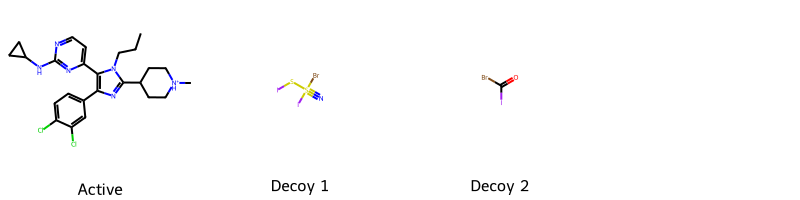

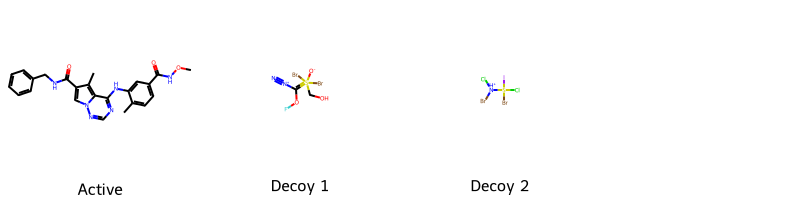

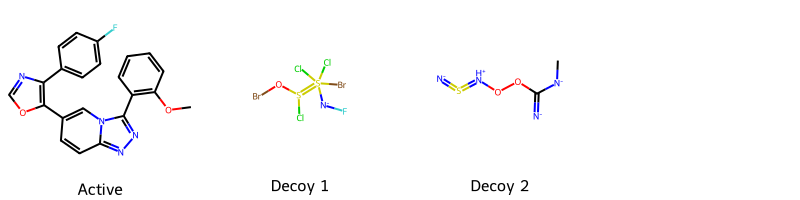

In [6]:
print(f'The shape of active_decoys_dict is: {len(active_decoys_dict)}')
active_decoys_dict

from rdkit import Chem
from rdkit.Chem import Draw

for act_smi, dec_smis in active_decoys_dict.items():
    act_mol = Chem.MolFromSmiles(act_smi)
    dec_mols = [Chem.MolFromSmiles(smi) for smi in dec_smis]
    display(Draw.MolsToGridImage([act_mol]+dec_mols, molsPerRow=4, subImgSize=(200,200), legends=['Active'] + [f'Decoy {i+1}' for i in range(len(dec_mols))]))